# Cats and Dogs (Transfer Learning - VGG16)

In [0]:
# Install TensorFlow
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf

TensorFlow 2.x selected.


In [0]:
# 
!wget -c https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip
!unzip -qq Cat_Dog_data.zip

--2019-10-28 08:26:27--  https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.163.149
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.163.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 580495262 (554M) [application/zip]
Saving to: ‘Cat_Dog_data.zip’

Cat_Dog_data.zip    100%[===================>] 553.60M  26.7MB/s    in 21s     

2019-10-28 08:26:49 (26.4 MB/s) - ‘Cat_Dog_data.zip’ saved [580495262/580495262]



## Data Preparation

In [0]:
import numpy as np
import os
import shutil
from os import listdir
from os.path import isfile, join

In [0]:
train_val_split = len(os.listdir("Cat_Dog_data/train/cat")) // 4
try:
  os.mkdir(os.path.join("Cat_Dog_data", 'validation'))
except Exception:
  pass
try:
  os.mkdir(os.path.join("Cat_Dog_data", 'validation/cat'))
except Exception:
  pass
try:
  os.mkdir(os.path.join("Cat_Dog_data", 'validation/dog'))
except Exception:
  pass
# Print directory structure
!find $"Cat_Dog_data" -type d -print
# list all files in the cat directory 
onlyfiles = [f for f in listdir("Cat_Dog_data/train/cat") if isfile(join("Cat_Dog_data/train/cat", f))]
print(len(onlyfiles))
# copy the first 1/4 to validation
for f in onlyfiles[:train_val_split]:
  shutil.move(os.path.join("Cat_Dog_data/train/cat", f), 'Cat_Dog_data/validation/cat')
# list all files in the cat directory 
onlyfiles = [f for f in listdir("Cat_Dog_data/train/dog") if isfile(join("Cat_Dog_data/train/dog", f))]
print(len(onlyfiles))
# copy the first 1/4 to validation
for f in onlyfiles[:train_val_split]:
  shutil.move(os.path.join("Cat_Dog_data/train/dog", f), 'Cat_Dog_data/validation/dog')
print("# cat val", len(os.listdir("Cat_Dog_data/validation/cat")))
print("# cat train", len(os.listdir("Cat_Dog_data/train/cat")))
print("# dog val", len(os.listdir("Cat_Dog_data/validation/dog")))
print("# dog train", len(os.listdir("Cat_Dog_data/train/dog")))

Cat_Dog_data
Cat_Dog_data/train
Cat_Dog_data/train/cat
Cat_Dog_data/train/dog
Cat_Dog_data/validation
Cat_Dog_data/validation/cat
Cat_Dog_data/validation/dog
Cat_Dog_data/test
Cat_Dog_data/test/cat
Cat_Dog_data/test/dog
11250
11250
# cat val 2812
# cat train 8438
# dog val 2812
# dog train 8438


In [0]:
base_dir = "Cat_Dog_data"

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cat')  # directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dog')  # directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cat')  # directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dog')  # directory with our validation dog pictures
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.model_selection import train_test_split

rows = 128
cols= 128

# Data Pre-processing

In [0]:
model = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=True)
model.summary()

553467904/553467096 [==============================] - 20s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
___________________________________________________________

In [0]:
model = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=False)
model.summary()

58892288/58889256 [==============================] - 2s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
______________________________________________________________

In [0]:
base_model = tf.keras.applications.vgg16.VGG16(weights='imagenet', 
                                               include_top=False, 
                                               input_shape=(128,128,3))

x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
predictions = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.train = False

In [0]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

x_train_datagen = ImageDataGenerator(rescale=1./255)
x_val_datagen = ImageDataGenerator(rescale=1./255)

train_datagen = x_train_datagen.flow_from_directory("Cat_Dog_data/train",
                                                    target_size=(rows,cols),
                                                    batch_size=40,
                                                    class_mode='binary')
val_datagen = x_val_datagen.flow_from_directory("Cat_Dog_data//validation",
                                                target_size=(rows,cols),
                                                batch_size=40,
                                                class_mode='binary')



Found 16876 images belonging to 2 classes.
Found 5624 images belonging to 2 classes.


In [0]:
epochs = 10

H = model.fit_generator(train_datagen,
                            steps_per_epoch=100,
                            epochs=epochs,
                            validation_data=val_datagen,
                            validation_steps=50)


Epoch 1/10
100/100 [==============================] - 69s 686ms/step - loss: 0.6904 - acc: 0.5468 - val_loss: 0.6688 - val_acc: 0.5635
Epoch 2/10
100/100 [==============================] - 61s 612ms/step - loss: 0.5940 - acc: 0.7143 - val_loss: 0.8555 - val_acc: 0.5440
Epoch 3/10
100/100 [==============================] - 65s 650ms/step - loss: 0.4048 - acc: 0.8141 - val_loss: 0.2301 - val_acc: 0.9085
Epoch 4/10
100/100 [==============================] - 61s 611ms/step - loss: 0.3207 - acc: 0.8633 - val_loss: 0.2601 - val_acc: 0.8745
Epoch 5/10
100/100 [==============================] - 61s 611ms/step - loss: 0.2689 - acc: 0.8860 - val_loss: 0.1771 - val_acc: 0.9345
Epoch 6/10
100/100 [==============================] - 61s 609ms/step - loss: 0.2213 - acc: 0.9078 - val_loss: 0.1701 - val_acc: 0.9370
Epoch 7/10
100/100 [==============================] - 61s 615ms/step - loss: 0.1849 - acc: 0.9234 - val_loss: 0.2051 - val_acc: 0.9205
Epoch 8/10
100/100 [==============================] - 6

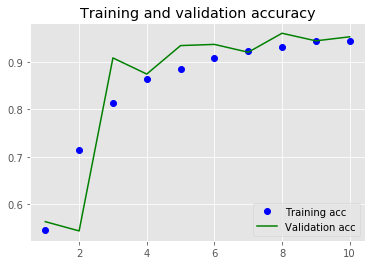

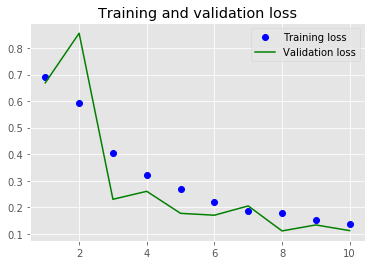

In [0]:
acc = H.history['acc']
val_acc = H.history['val_acc']
loss = H.history['loss']
val_loss = H.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'g', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

References:

1. [Anthony Tanbakuchi](http://tanbakuchi.com/posts/comparison-of-openv-interpolation-algorithms/ )







